# Home assignment 1.2: Ground Detection (RANSAC)

Goal: detect ground plane from a 3D point cloud so the robot can distinguish drivable area from obstacles.

This notebook uses **KITTI data from `data/3d`**.
In this local subset there are no Velodyne `.bin` files, so the 3D cloud is reconstructed from stereo images (`image_2`, `image_3`) and calibration files.

## Pipeline

1. Load 3D point cloud.
2. Implement RANSAC plane fitting:
   - sample 3 random points,
   - build plane `ax + by + cz + d = 0`,
   - compute distance from all points to plane,
   - count inliers,
   - repeat `N` times and keep best plane.
3. Color ground points and obstacle points differently.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

%matplotlib inline

np.random.seed(42)


## 1) Load KITTI stereo frame and calibration

left image + right image + calibrate = stereo

In [2]:
DATA_ROOT = Path('data/3d')
FRAME_ID = '000100'
SPLIT = 'training'


def load_kitti_calib(calib_path):
    """Parse KITTI calibration text into numpy arrays."""
    calib = {}
    with open(calib_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            key, values = line.split(':', 1)
            nums = np.array([float(v) for v in values.strip().split()], dtype=float)
            if nums.size == 12:
                calib[key] = nums.reshape(3, 4)
            elif nums.size == 9:
                calib[key] = nums.reshape(3, 3)
            else:
                calib[key] = nums
    return calib


def load_stereo_pair(data_root, frame_id, split='training'):
    """Load left/right KITTI images and calibration for one frame."""
    left_path = data_root / 'data_object_image_2' / split / 'image_2' / f'{frame_id}.png'
    right_path = data_root / 'data_object_image_3' / split / 'image_3' / f'{frame_id}.png'
    calib_path = data_root / 'data_object_calib' / split / 'calib' / f'{frame_id}.txt'

    if not left_path.exists() or not right_path.exists() or not calib_path.exists():
        raise FileNotFoundError(
            'Missing files for frame {}:\n{}\n{}\n{}'.format(
                frame_id, left_path, right_path, calib_path
            )
        )

    left_bgr = cv2.imread(str(left_path), cv2.IMREAD_COLOR)
    right_bgr = cv2.imread(str(right_path), cv2.IMREAD_COLOR)
    if left_bgr is None or right_bgr is None:
        raise ValueError('Failed to read stereo images.')

    left_rgb = cv2.cvtColor(left_bgr, cv2.COLOR_BGR2RGB)
    right_rgb = cv2.cvtColor(right_bgr, cv2.COLOR_BGR2RGB)

    left_gray = cv2.cvtColor(left_bgr, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_bgr, cv2.COLOR_BGR2GRAY)

    calib = load_kitti_calib(calib_path)
    return left_rgb, right_rgb, left_gray, right_gray, calib


left_rgb, right_rgb, left_gray, right_gray, calib = load_stereo_pair(DATA_ROOT, FRAME_ID, SPLIT)

print('Frame:', FRAME_ID)
print('Left image shape:', left_rgb.shape)
print('Right image shape:', right_rgb.shape)
print('Calibration keys:', sorted(calib.keys()))


Frame: 000100
Left image shape: (375, 1242, 3)
Right image shape: (375, 1242, 3)
Calibration keys: ['P0', 'P1', 'P2', 'P3', 'R0_rect', 'Tr_imu_to_velo', 'Tr_velo_to_cam']


Plot left and right image

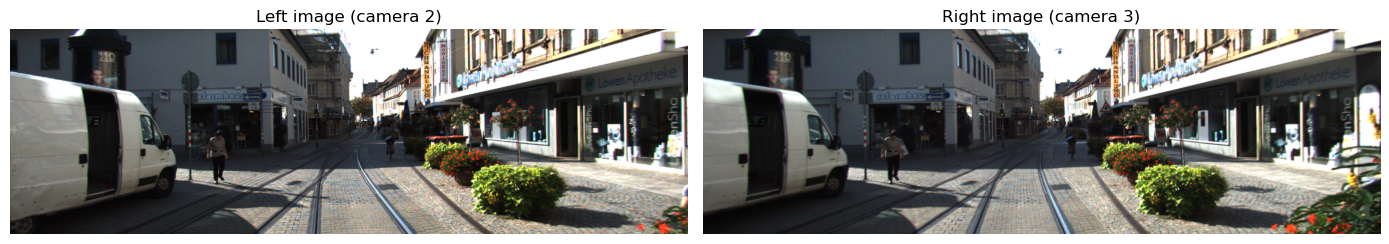

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(left_rgb)
axes[0].set_title('Left image (camera 2)')
axes[0].axis('off')

axes[1].imshow(right_rgb)
axes[1].set_title('Right image (camera 3)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 2) Stereo disparity -> 3D point cloud

Compute depth map

In [4]:
def compute_disparity_sgbm(left_gray, right_gray):
    """Compute dense stereo disparity with StereoSGBM."""
    num_disp = 128
    block_size = 5

    matcher = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=num_disp,
        blockSize=block_size,
        P1=8 * block_size * block_size,
        P2=32 * block_size * block_size,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=50,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
    )

    disp = matcher.compute(left_gray, right_gray).astype(np.float32) / 16.0
    return disp


def stereo_to_point_cloud(disparity, left_rgb, P2, P3,
                          min_disp=1.0,
                          min_depth=2.0,
                          max_depth=45.0,
                          roi_bottom_ratio=0.45):
    """
    Convert disparity map to 3D points in camera-2 coordinates.

    Camera coordinates:
    - x: right
    - y: down
    - z: forward
    """
    fx = P2[0, 0]
    fy = P2[1, 1]
    cx = P2[0, 2]
    cy = P2[1, 2]

    baseline = abs((P3[0, 3] - P2[0, 3]) / fx)

    h, w = disparity.shape
    u_grid, v_grid = np.meshgrid(np.arange(w), np.arange(h))

    valid = disparity > min_disp

    valid &= (v_grid >= int(roi_bottom_ratio * h))

    z = fx * baseline / np.maximum(disparity, 1e-6)
    x = (u_grid - cx) * z / fx
    y = (v_grid - cy) * z / fy

    valid &= np.isfinite(z)
    valid &= (z >= min_depth) & (z <= max_depth)
    valid &= np.abs(x) <= 35.0
    valid &= np.abs(y) <= 5.0

    points = np.column_stack([x[valid], y[valid], z[valid]]).astype(np.float32)
    colors = (left_rgb[valid] / 255.0).astype(np.float32)

    return points, colors, baseline


disparity = compute_disparity_sgbm(left_gray, right_gray)
points_all, colors_all, baseline = stereo_to_point_cloud(disparity, left_rgb, calib['P2'], calib['P3'])

print('Disparity shape:', disparity.shape)
print('Baseline (m):', round(float(baseline), 4))
print('Point cloud size:', len(points_all))


Disparity shape: (375, 1242)
Baseline (m): 0.5327
Point cloud size: 204808


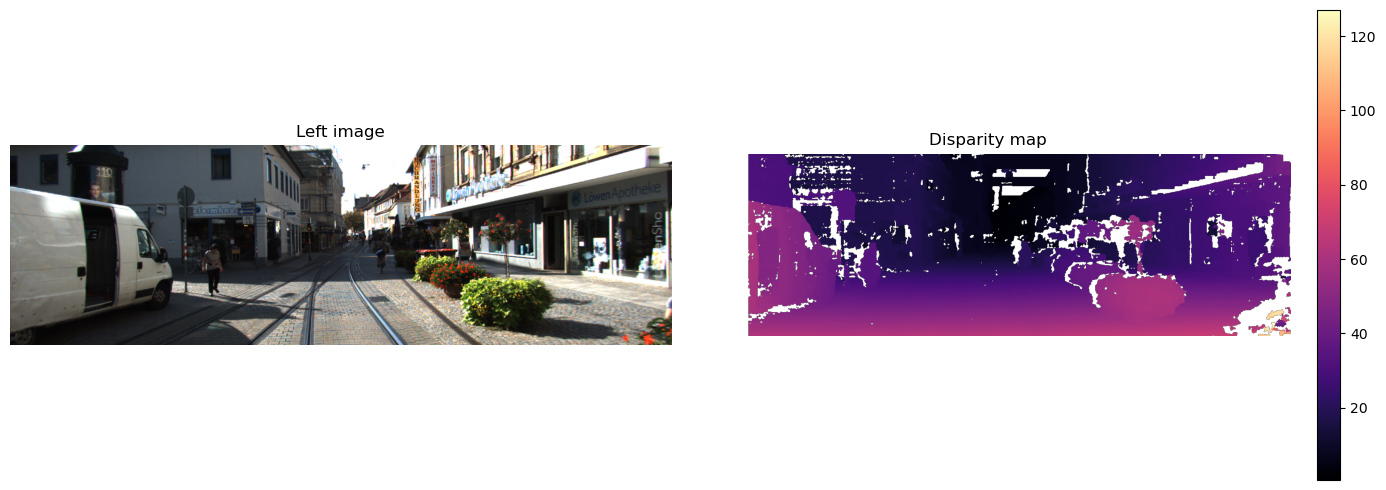

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(left_rgb)
axes[0].set_title('Left image')
axes[0].axis('off')

im = axes[1].imshow(np.where(disparity > 0, disparity, np.nan), cmap='magma')
axes[1].set_title('Disparity map')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## 3) RANSAC plane fitting (custom implementation)

In [6]:
def fit_plane_from_3_points(p1, p2, p3, eps=1e-8):
    """Return normalized plane (a, b, c, d) from 3 points, or None if degenerate."""
    v1 = p2 - p1
    v2 = p3 - p1
    normal = np.cross(v1, v2)
    norm = np.linalg.norm(normal)
    if norm < eps:
        return None

    normal = normal / norm
    d = -np.dot(normal, p1)
    a, b, c = normal
    return np.array([a, b, c, d], dtype=np.float64)


def point_plane_distances(points, plane):
    """Compute point-to-plane distances for plane ax+by+cz+d=0."""
    a, b, c, d = plane
    return np.abs(points @ np.array([a, b, c]) + d)


def refine_plane_least_squares(points_inliers):
    """Refine plane parameters by SVD using inlier points."""
    centroid = points_inliers.mean(axis=0)
    centered = points_inliers - centroid
    _, _, vt = np.linalg.svd(centered, full_matrices=False)
    normal = vt[-1]
    normal = normal / np.linalg.norm(normal)
    d = -np.dot(normal, centroid)
    return np.array([normal[0], normal[1], normal[2], d], dtype=np.float64)


def ransac_plane(points,
                 num_iterations=500,
                 distance_threshold=0.15,
                 min_inliers=500,
                 random_seed=42):
    """RANSAC plane detection.

    Steps per iteration:
    1) sample 3 random points,
    2) build plane equation,
    3) compute distances,
    4) count inliers,
    5) keep best.
    """
    rng = np.random.default_rng(random_seed)

    n = len(points)
    if n < 3:
        raise ValueError('Need at least 3 points for plane fitting.')

    best_plane = None
    best_inlier_mask = None
    best_count = 0

    for _ in range(num_iterations):
        idx = rng.choice(n, size=3, replace=False)
        p1, p2, p3 = points[idx]

        plane = fit_plane_from_3_points(p1, p2, p3)
        if plane is None:
            continue

        distances = point_plane_distances(points, plane)
        inlier_mask = distances < distance_threshold
        count = int(np.count_nonzero(inlier_mask))

        if count > best_count:
            best_count = count
            best_plane = plane
            best_inlier_mask = inlier_mask

    if best_plane is None or best_count < min_inliers:
        raise RuntimeError('RANSAC failed to find a valid plane.')

    refined_plane = refine_plane_least_squares(points[best_inlier_mask])
    refined_dist = point_plane_distances(points, refined_plane)
    refined_mask = refined_dist < distance_threshold

    return refined_plane, refined_mask


Compute the space equation

In [7]:
max_fit_points = 60000
if len(points_all) > max_fit_points:
    rng = np.random.default_rng(42)
    fit_idx = rng.choice(len(points_all), size=max_fit_points, replace=False)
    points_fit = points_all[fit_idx]
else:
    points_fit = points_all.copy()

print('Points for fitting:', len(points_fit))

plane_fit, inliers_fit = ransac_plane(
    points_fit,
    num_iterations=600,
    distance_threshold=0.15,
    min_inliers=1200,
    random_seed=42,
)

dist_all = point_plane_distances(points_all, plane_fit)
ground_mask = dist_all < 0.15
obstacle_mask = ~ground_mask

a, b, c, d = plane_fit
print('Plane equation:')
print(f'  {a:.6f} * x + {b:.6f} * y + {c:.6f} * z + {d:.6f} = 0')
print('Ground points:', int(np.count_nonzero(ground_mask)))
print('Obstacle points:', int(np.count_nonzero(obstacle_mask)))
print('Ground ratio:', f"{100.0 * np.mean(ground_mask):.2f}%")


Points for fitting: 60000
Plane equation:
  -0.029709 * x + -0.999551 * y + 0.003936 * z + 1.621148 = 0
Ground points: 116325
Obstacle points: 88483
Ground ratio: 56.80%


## 4) Color ground vs obstacles

Green - ground

In [8]:

seg_colors = np.zeros((len(points_all), 3), dtype=np.float32)
seg_colors[ground_mask] = np.array([0.15, 0.85, 0.20], dtype=np.float32)   # green = ground
seg_colors[obstacle_mask] = np.array([0.90, 0.20, 0.20], dtype=np.float32) # red = obstacles

forward = points_all[:, 2]
left = -points_all[:, 0]
up = -points_all[:, 1]


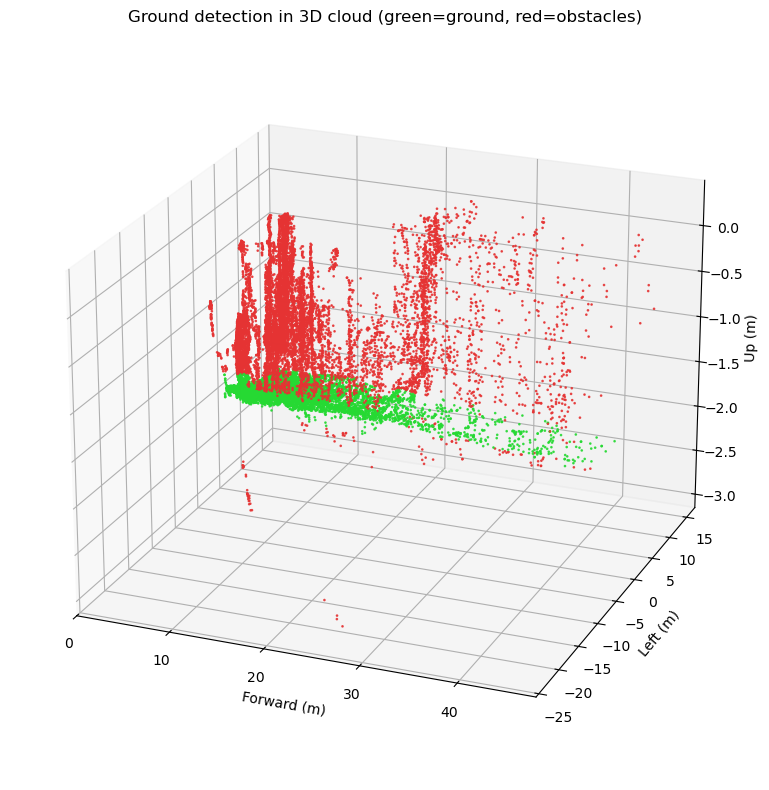

In [9]:
max_vis = 25000
if len(points_all) > max_vis:
    rng = np.random.default_rng(7)
    vis_idx = rng.choice(len(points_all), size=max_vis, replace=False)
else:
    vis_idx = np.arange(len(points_all))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    forward[vis_idx],
    left[vis_idx],
    up[vis_idx],
    c=seg_colors[vis_idx],
    s=0.8,
    alpha=0.85,
)
ax.set_title('Ground detection in 3D cloud (green=ground, red=obstacles)')
ax.set_xlabel('Forward (m)')
ax.set_ylabel('Left (m)')
ax.set_zlabel('Up (m)')
ax.view_init(elev=22, azim=-68)
plt.tight_layout()
plt.show()


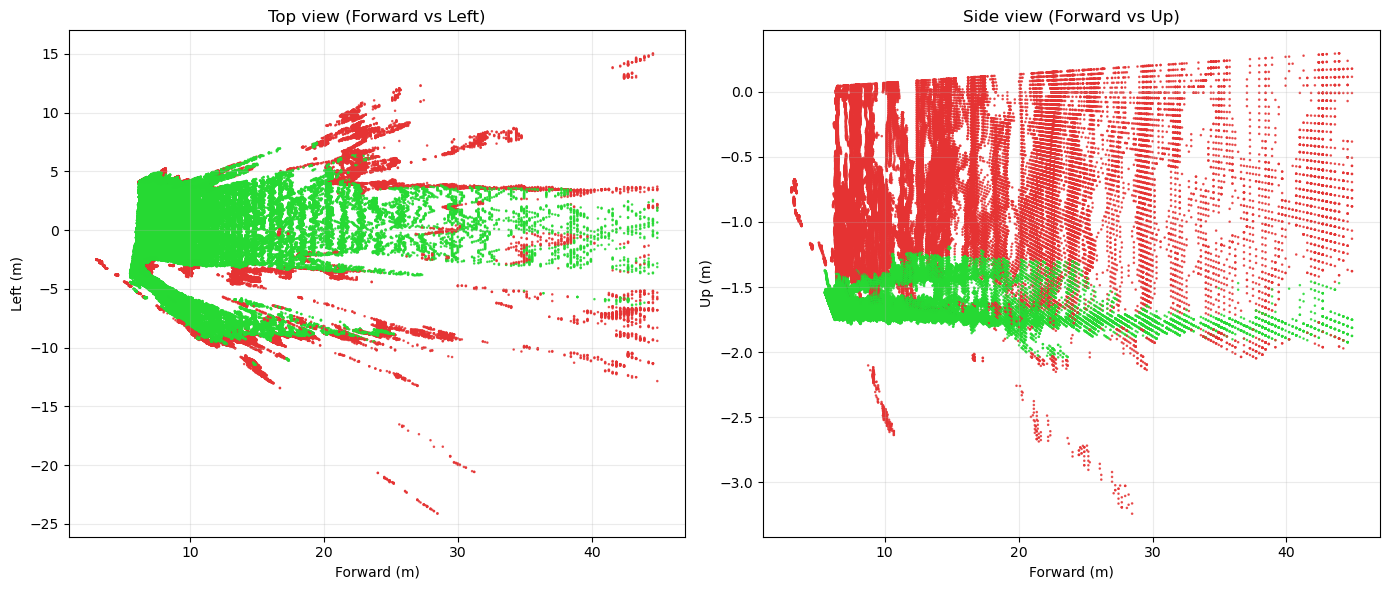

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(forward, left, c=seg_colors, s=0.7, alpha=0.8)
axes[0].set_title('Top view (Forward vs Left)')
axes[0].set_xlabel('Forward (m)')
axes[0].set_ylabel('Left (m)')
axes[0].grid(alpha=0.25)

axes[1].scatter(forward, up, c=seg_colors, s=0.7, alpha=0.8)
axes[1].set_title('Side view (Forward vs Up)')
axes[1].set_xlabel('Forward (m)')
axes[1].set_ylabel('Up (m)')
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()


## Conclusion

The stereo pipeline produced a dense 3D point cloud (204,808 points) from a (375\times1242) disparity map using a 0.5327 m baseline, with visible noise/outliers typical for stereo matching. RANSAC plane fitting on a 60k subsample estimated a near-horizontal dominant plane (ground) and classified points by distance to this plane. As a result, 116,325 points (56.8%) were labeled as ground and 88,483 (43.2%) as obstacles; the visualizations confirm a coherent ground “carpet” and vertical/non-planar structures as obstacles, with remaining misclassifications mostly driven by disparity artifacts.
